# Utilizarea Rețelei Generativ Adversariale StarGAN în aplicații practice


## Pași inițiali pentru utilizare

Pentru acestă parte a proiectului, am fi putut folosi variantele de StarGAN implementate în Pytorch, Tensorflow sau nnabla. Am decis să utilizăm preponderent modulul nnabla, pentru că oferă un model mult mai customizabil și pe care l-am mai tweak-uit pentru a efectua exact operațiile necesare pentru procesările de imagini.

Inițial, trebuie să clonăm proiectul de pe repositoriul de Github și să instalam modulul *nnabla-ext-cuda100* pentru a putea utiliza placa video pentru modelele din modulul **nnabla**.

In [1]:
!pip install nnabla-ext-cuda100
!git clone https://github.com/DreamUnibucTeam/Practical-Applications-of-StarGAN.git
# %run nnabla-examples/interactive-demos/colab_utils.py
%cd Practical-Applications-of-StarGAN/nnabla-stargan/

     |████████████████████████████████| 51.1 MB 19.2 MB/s 
     |████████████████████████████████| 18.1 MB 36.3 MB/s 
     |████████████████████████████████| 132 kB 30.4 MB/s 
     |████████████████████████████████| 8.7 MB 22.9 MB/s 
     |████████████████████████████████| 79 kB 7.6 MB/s 
     |████████████████████████████████| 138 kB 46.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Cloning into 'Practical-Applications-of-StarGAN'...
remote: Enumerating objects: 46, done.
remote: Counting o

Obținem modelul preantrenat de StarGAN din **nnabla**, antrenat pe fețele din setul de date *CelebA*, împreună cu fișierul JSON care conține configurația modelului, necesară pentru a-l rula.

In [2]:
!wget https://nnabla.org/pretrained-models/nnabla-examples/GANs/stargan/pretrained_params_on_celebA.h5
!wget https://nnabla.org/pretrained-models/nnabla-examples/GANs/stargan/pretrained_conf_on_celebA.json

--2022-04-17 13:59:31--  https://nnabla.org/pretrained-models/nnabla-examples/GANs/stargan/pretrained_params_on_celebA.h5
Resolving nnabla.org (nnabla.org)... 18.160.200.12, 18.160.200.38, 18.160.200.40, ...
Connecting to nnabla.org (nnabla.org)|18.160.200.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 212881888 (203M) [binary/octet-stream]
Saving to: ‘pretrained_params_on_celebA.h5’

pretrained_params_o 100%[===================>] 203.02M  52.6MB/s    in 4.3s    

2022-04-17 13:59:36 (47.5 MB/s) - ‘pretrained_params_on_celebA.h5’ saved [212881888/212881888]

--2022-04-17 13:59:36--  https://nnabla.org/pretrained-models/nnabla-examples/GANs/stargan/pretrained_conf_on_celebA.json
Resolving nnabla.org (nnabla.org)... 18.160.200.12, 18.160.200.38, 18.160.200.40, ...
Connecting to nnabla.org (nnabla.org)|18.160.200.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 775 [application/json]
Saving to: ‘pretrained_conf_on_celebA.json’

pre

Modelul de StarGAN ar trebui să primească ca input o imagine care conține regiunea feței persoanei, iar din acest motiv, dacă primim ca input o imagine ce conține mai multe detalii, nu doar regiunea facială, ar trebui să facem crop feței sau fețelor din acea imagine.

Pentru acesta, putem folosi modelul de detecție facială din modulul **dlib** sau **MTCNN** implementat în librăria Pytorch.

In [3]:
!wget http://dlib.net/files/mmod_human_face_detector.dat.bz2
!bzip2 -d mmod_human_face_detector.dat.bz2

--2022-04-17 13:59:43--  http://dlib.net/files/mmod_human_face_detector.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694709 (678K)
Saving to: ‘mmod_human_face_detector.dat.bz2’

mmod_human_face_det 100%[===================>] 678.43K  4.41MB/s    in 0.2s    

2022-04-17 13:59:43 (4.41 MB/s) - ‘mmod_human_face_detector.dat.bz2’ saved [694709/694709]



Importam, de asemenea, modulele globale necesare pentru proiectul nostru.

In [119]:
import cv2 as cv
import dlib
import numpy as np
from skimage import io, color
import matplotlib.pyplot as plt
from nnabla.utils.image_utils import imread, imresize, imsave


import os
import shutil

# import torch
# import torch.nn as nn

Inițializăm detectorul facial din modulul **dlib** pentru a putea fi utilizat în funcțiile următoare.

In [5]:
face_detector = dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")

De asemenea, vom avea nevoie și de câteva funcții utilitare (*transform* și *crop*) pentru a putea procesa imaginile. Aceste funcții au fost obținute din modelul [FAN: Facial Alignment Network](https://github.com/sony/nnabla-examples/tree/master/facial-keypoint-detection/face-alignment) și simplificate doar pentru task-ul nostru.

In [46]:
def transform(point, center, scale, resolution, invert=False):
    """Generate and affine transformation matrix.
    Given a set of points, a center, a scale and a target resolution, the
    function generates and affine transformation matrix. If invert is ``True``
    it will produce the inverse transformation.
    Arguments:
        point {numpy.array} -- the input 2D point
        center {numpy.array} -- the center around which to perform the transformations
        scale {float} -- the scale of the face/object
        resolution {float} -- the output resolution
    Keyword Arguments:
        invert {bool} -- define wherever the function should produce the direct or the
        inverse transformation matrix (default: {False})
    """
    point.append(1)

    h = 200.0 * scale
    t = np.eye(3)
    t[0, 0] = resolution / h
    t[1, 1] = resolution / h
    t[0, 2] = resolution * (-center[0] / h + 0.5)
    t[1, 2] = resolution * (-center[1] / h + 0.5)

    if invert:
        t = np.reshape(np.linalg.inv(np.reshape(t, [1, 3, 3])), [3, 3])

    new_point = np.reshape(np.matmul(
        np.reshape(t, [1, 3, 3]), np.reshape(point, [1, 3, 1])), [3, ])[0:2]

    return new_point.astype(int)


def crop(image, center, scale, resolution=256, show_transformed=True):
    """Center crops an image or set of heatmaps
    Arguments:
        image {numpy.array} -- an rgb image
        center {numpy.array} -- the center of the object, usually the same as of the bounding box
        scale {float} -- scale of the face
    Keyword Arguments:
        resolution {float} -- the size of the output cropped image (default: {256.0})
    Returns:
        [type] -- [description]
    """  # Crop around the center point
    """ Crops the image around the center. Input is expected to be an np.ndarray """
    ul = transform([1, 1], center, scale, resolution, True)
    br = transform([resolution, resolution], center, scale, resolution, True)
    
    # Afisarea dupa transformarea afina
    if show_transformed:
        print(f"Detectia dupa transformarea afina (upper-left = {ul}, bottom-right = {br}):")
        test_img = cv.cvtColor(image.copy(), cv.COLOR_RGB2BGR)
        cv.rectangle(test_img, tuple(ul), tuple(br), (0,255,0), 1)
        cv2_imshow(test_img)

    if image.ndim > 2:
        newDim = np.array([br[1] - ul[1], br[0] - ul[0],
                           image.shape[2]], dtype=np.int32)
        newImg = np.zeros(newDim, dtype=np.uint8)
    else:
        newDim = np.array([br[1] - ul[1], br[0] - ul[0]], dtype=np.int)
        newImg = np.zeros(newDim, dtype=np.uint8)
    ht = image.shape[0]
    wd = image.shape[1]
    newX = np.array(
        [max(1, -ul[0] + 1), min(br[0], wd) - ul[0]], dtype=np.int32)
    newY = np.array(
        [max(1, -ul[1] + 1), min(br[1], ht) - ul[1]], dtype=np.int32)
    oldX = np.array(
        [int(max(1, ul[0] + 1)), int(min(br[0], wd))], dtype=np.int32)
    oldY = np.array(
        [int(max(1, ul[1] + 1)), int(min(br[1], ht))], dtype=np.int32)

    newImg[newY[0] - 1:newY[1], newX[0] - 1:newX[1]
           ] = image[oldY[0] - 1:oldY[1], oldX[0] - 1:oldX[1], :]

    newImg = cv.resize(newImg, dsize=(int(resolution), int(resolution)),
                        interpolation=cv.INTER_LINEAR)
    return newImg, ul, br

### 1. Testarea modelului StarGAN cu selfie-uri

Pentru prima aplicație, vom testa modelul preantrenat de StarGAN pe selfie-uri. Pentru aceasta, dacă mașina utilizatorului are o cameră video, puteți rula următorul cod pentru a face un selfie, apoi să procesăm 

<IPython.core.display.Javascript object>

Captura a fost salvata in fisierul capture.png


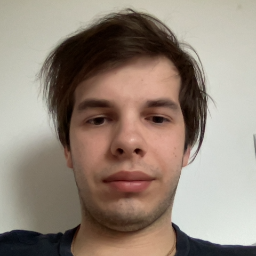

In [66]:
# Atentie la acest import! 
# Trebuie sa va asigurati ca sunteti in folderul nnabla-stargan
from utils.colab_utils import take_photo
from google.colab.patches import cv2_imshow

try:
    img_path = "capture.png"
    image_name = take_photo(filename=img_path, cam_width=256, cam_height=256)
    print('Captura a fost salvata in fisierul {}'.format(image_name))
    
    # Afisarea imaginii obținute
    img = cv.imread(image_name)
    cv2_imshow(img)
except Exception as err:
    print(str(err))

Transferăm poza într-un alt folder.

In [67]:
os.makedirs("selfies/processed", exist_ok=True)
shutil.move(img_path, f"selfies/{img_path}")

'selfies/capture.png'

Vom folosi apoi o funcție de procesare a capturii pentru a extrage regiunea feței pentru a putea să o trecem prin modelul nostru de StarGAN.

In [68]:
def process_captured_image(img_name, output_img_name, face_detector, face_detector_lib='dlib'):
    img = io.imread(img_name)
    if img.ndim == 2:
        img = color.gray2rgb(img)
    elif img.shape[-1] == 4:
        img = img[..., :3]

    # Daca folosim detectorul din dlib, acestea vor fi fețele detectate
    if face_detector_lib == 'dlib':
        detected_faces = face_detector(cv.cvtColor(img[..., ::-1].copy(), cv.COLOR_BGR2GRAY))
        detected_faces = [[d.rect.left(), d.rect.top(), d.rect.right(), d.rect.bottom()] for d in detected_faces]

    assert len(detected_faces) == 1, "Atentie: Poza trebuie sa contina o singura fata."
    face = detected_faces[0]

    # Afisarea detectiei faciale
    print("Detectia faciala:")
    test_img = cv.cvtColor(img.copy(), cv.COLOR_RGB2BGR)
    cv.rectangle(test_img, (face[0], face[1]), (face[2], face[3]), (255,0 ,0), 1)
    cv2_imshow(test_img)

    center = [face[2] - (face[2] - face[0]) / 2.0,
            face[3] - (face[3] - face[1]) / 2.0]
    scale = (face[2] - face[0] + face[3] - face[1]) / 195
    cropped_img, ul, br = crop(img, center, scale, resolution=128)
    plt.imshow(cropped_img)

    io.imsave(output_img_name, cropped_img)
    return cropped_img, ul, br

Detectia faciala:


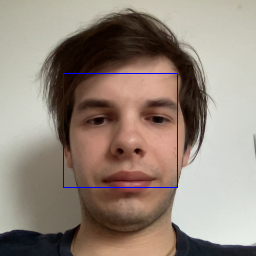

Detectia dupa transformarea afina (upper-left = [ 4 14], bottom-right = [236 246]):


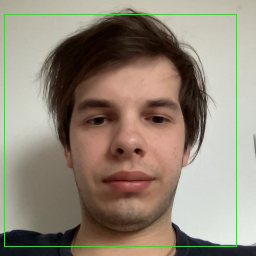

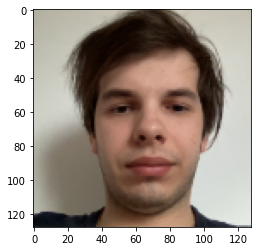

In [69]:
face_img, ul, br = process_captured_image(
    img_name=f"selfies/{img_path}", 
    output_img_name=f"selfies/processed/face_{img_path}", 
    face_detector=face_detector)

În continuare, după ce am obținut poza cropată cu fața, putem să o trecem prin StarGAN și să selectăm ce atribute dorim să modificăm.

**Atenție!** Pentru a rula pe imaginea obținută, trebuie să indicație path-ul corect către imagine.

In [93]:
!python generate.py --pretrained-params pretrained_params_on_celebA.h5 --config pretrained_conf_on_celebA.json --test-image-path ./selfies/processed/ --result-save-path ./selfies/generated/

2022-04-17 15:43:29,867 [nnabla][INFO]: Initializing CPU extension...
2022-04-17 15:43:30,237 [nnabla][INFO]: Initializing CUDA extension...
2022-04-17 15:43:30,242 [nnabla][INFO]: Initializing cuDNN extension...
Learned attributes choice: ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']
Source image: face_capture.png
Use 'Black_Hair'?
type yes or no: yes
Use 'Blond_Hair'?
type yes or no: no
Use 'Brown_Hair'?
type yes or no: no
Use 'Male'?
type yes or no: yes
Use 'Young'?
type yes or no: yes
Saved ./selfies/generated/generated_0_Black_Hair_Male_Young.png.


Putem să afișăm acum imaginea procesată cu ajutorul StarGAN-ului. Putem să o comparăm și cu poza inițială.

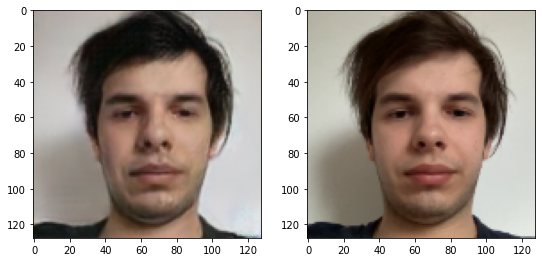

In [120]:
generated_img = imread("./selfies/generated/generated_0_Black_Hair_Male_Young.png")
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 9))
ax1.imshow(generated_img)
ax2.imshow(face_img)
plt.show()

Putem să înlocuim imaginea obținută în poza inițială și să observăm cum arată.

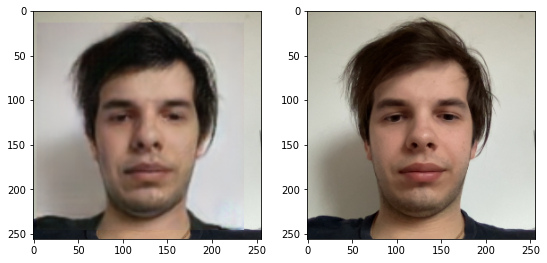

In [125]:
img = imread(f"./selfies/{img_path}")
orig_img = img.copy()

if img.shape[-1] == 4:
    img = img[..., :3]
(x0, y0), (x1, y1) = ul, br
resized_gen = imresize(generated_img, (x1 - x0, y1 - y0))
img[y0:y1, x0:x1, :] = resized_gen

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 9))
ax1.imshow(img)
ax2.imshow(orig_img)
plt.show()